# PK Document Classification with BERT Embeddings and XGBoost

## Data Preprocessing and Exploration

In [1]:
# load packages
import os
import pandas as pd
import numpy as np
import seaborn as sns
!pip install wordcloud
!pip install imblearn

In [2]:
# Mount your Google Drive so you can read in data from there (you need to allow permissions when pop-up comes)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# load in labelled data
labelled_df = pd.read_csv('/content/drive/My Drive/PKPDAI_Paper_Classification/trainingdata.Y.label.review.final.csv')

labelled_df = labelled_df[["Pubmed ID", "Label By Reviewer 1 (Y/N)"]]

labelled_df = labelled_df.rename(columns={"Pubmed ID": "pmid"})
labelled_df = labelled_df.rename(columns={"Label By Reviewer 1 (Y/N)": "Final_Label"})
labelled_df.drop_duplicates(subset=["pmid"], keep='first', inplace=True)
print(labelled_df.info())

labelled_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 987 entries, 0 to 986
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   pmid         987 non-null    int64 
 1   Final_Label  987 non-null    object
dtypes: int64(1), object(1)
memory usage: 15.5+ KB
None


,pmid,Final_Label
0,1127135,N
1,1271155,N
2,1097636,Y
3,25334,N
4,10124,Y


In [4]:
# load in raw data with text fields
text_df = pd.read_csv('/content/drive/My Drive/PKPDAI_Paper_Classification/allpmids_withmetadata.csv')
text_df = text_df.drop("Unnamed: 0", axis = 1)

In [5]:
text_df.drop_duplicates(subset=["pmid"], keep='first', inplace=True)
print(text_df.info())
text_df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 63383 entries, 0 to 66814
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   pmid        63383 non-null  int64 
 1   date        63383 non-null  object
 2   title       63383 non-null  object
 3   authors     63383 non-null  object
 4   journal     63383 non-null  object
 5   abstract    63383 non-null  object
 6   mesh_terms  63383 non-null  object
dtypes: int64(1), object(6)
memory usage: 3.9+ MB
None


,pmid,date,title,authors,journal,abstract,mesh_terms
0,23274625,"{'Year': '2013', 'Month': '06', 'Day': '25'}",Development and validation of an LC-MS/MS meth...,ListElement([DictElement({'AffiliationInfo': [...,"{'ISSN': StringElement('1873-376X', attributes...",['Tolvaptan is a selective vasopressin V(2)-re...,"[{'QualifierName': [], 'DescriptorName': Strin..."
1,16080280,"{'Year': '2005', 'Month': '08', 'Day': '26'}",Determination of the transdermal bioavailabili...,ListElement([DictElement({'AffiliationInfo': [...,"{'ISSN': StringElement('0004-4172', attributes...",['Two different transdermal diclofenac (CAS 15...,"[{'QualifierName': [], 'DescriptorName': Strin..."
2,30134590,"{'Year': '2018', 'Month': '12', 'Day': '11'}",Bioavailability of Vitamin B<sub>12</sub> from...,ListElement([DictElement({'AffiliationInfo': [...,"{'ISSN': StringElement('2072-6643', attributes...",['The present study compares the bioavailabili...,"[{'QualifierName': [], 'DescriptorName': Strin..."
3,22071596,"{'Year': '2012', 'Month': '07', 'Day': '27'}",Phase I study of continuous afatinib (BIBW 299...,ListElement([DictElement({'AffiliationInfo': [...,"{'ISSN': StringElement('1432-0843', attributes...",[StringElement('This Phase I study determined ...,"[{'QualifierName': [], 'DescriptorName': Strin..."
4,22352370,"{'Year': '2012', 'Month': '06', 'Day': '14'}",Pharmacokinetics of 250 μg anti-D IgG in the t...,ListElement([DictElement({'AffiliationInfo': [...,"{'ISSN': StringElement('1600-0412', attributes...",[StringElement('We present a pharmacokinetic s...,"[{'QualifierName': [], 'DescriptorName': Strin..."


In [6]:
# combine dataframes to collate fields we want
final_df = pd.merge(labelled_df, text_df, on=["pmid"])
final_df.drop_duplicates(subset=["pmid"], keep='first', inplace=True)
print(final_df.info())
final_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 987 entries, 0 to 986
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   pmid         987 non-null    int64 
 1   Final_Label  987 non-null    object
 2   date         987 non-null    object
 3   title        987 non-null    object
 4   authors      987 non-null    object
 5   journal      987 non-null    object
 6   abstract     987 non-null    object
 7   mesh_terms   987 non-null    object
dtypes: int64(1), object(7)
memory usage: 61.8+ KB
None


,pmid,Final_Label,date,title,authors,journal,abstract,mesh_terms
0,1127135,N,"{'Year': '1975', 'Month': '07', 'Day': '14'}",Naproxen metabolism in man.,ListElement([DictElement({'AffiliationInfo': [...,"{'ISSN': StringElement('0091-2700', attributes...","['In summary, naproxen is an acidic, highly al...",[{'QualifierName': [StringElement('administrat...
1,1271155,N,"{'Year': '1976', 'Month': '08', 'Day': '02'}",Pharmacokinetic analysis of the disposition of...,ListElement([DictElement({'AffiliationInfo': [...,"{'ISSN': StringElement('0022-3476', attributes...",['The disposition of a single intravenous dose...,"[{'QualifierName': [], 'DescriptorName': Strin..."
2,1097636,Y,"{'Year': '1975', 'Month': '11', 'Day': '06'}","Absorption, distribution, and metabolic fate o...",ListElement([DictElement({'AffiliationInfo': [...,"{'ISSN': StringElement('0022-3549', attributes...",['The absorption and metabolic fate of 7-chlor...,"[{'QualifierName': [], 'DescriptorName': Strin..."
3,25334,N,"{'Year': '1978', 'Month': '06', 'Day': '17'}","Pharmacokinetic studies on ditazole, a novel i...",ListElement([DictElement({'AffiliationInfo': [...,"{'ISSN': StringElement('0022-3549', attributes...",['The distribution of ditazole in blood and ti...,"[{'QualifierName': [], 'DescriptorName': Strin..."
4,10124,Y,"{'Year': '1976', 'Month': '12', 'Day': '23'}",Pharmacokinetics of oxprenolol in normal subje...,ListElement([DictElement({'AffiliationInfo': [...,"{'ISSN': StringElement('0009-9236', attributes...",['The effect of oxprenolol administered intrav...,"[{'QualifierName': [], 'DescriptorName': Strin..."


In [7]:
final_df["abstract"] = final_df['abstract'].apply(lambda x: str(x).replace('[','').replace(']',''))
final_df.head()

,pmid,Final_Label,date,title,authors,journal,abstract,mesh_terms
0,1127135,N,"{'Year': '1975', 'Month': '07', 'Day': '14'}",Naproxen metabolism in man.,ListElement([DictElement({'AffiliationInfo': [...,"{'ISSN': StringElement('0091-2700', attributes...","'In summary, naproxen is an acidic, highly alb...",[{'QualifierName': [StringElement('administrat...
1,1271155,N,"{'Year': '1976', 'Month': '08', 'Day': '02'}",Pharmacokinetic analysis of the disposition of...,ListElement([DictElement({'AffiliationInfo': [...,"{'ISSN': StringElement('0022-3476', attributes...",'The disposition of a single intravenous dose ...,"[{'QualifierName': [], 'DescriptorName': Strin..."
2,1097636,Y,"{'Year': '1975', 'Month': '11', 'Day': '06'}","Absorption, distribution, and metabolic fate o...",ListElement([DictElement({'AffiliationInfo': [...,"{'ISSN': StringElement('0022-3549', attributes...",'The absorption and metabolic fate of 7-chloro...,"[{'QualifierName': [], 'DescriptorName': Strin..."
3,25334,N,"{'Year': '1978', 'Month': '06', 'Day': '17'}","Pharmacokinetic studies on ditazole, a novel i...",ListElement([DictElement({'AffiliationInfo': [...,"{'ISSN': StringElement('0022-3549', attributes...",'The distribution of ditazole in blood and tis...,"[{'QualifierName': [], 'DescriptorName': Strin..."
4,10124,Y,"{'Year': '1976', 'Month': '12', 'Day': '23'}",Pharmacokinetics of oxprenolol in normal subje...,ListElement([DictElement({'AffiliationInfo': [...,"{'ISSN': StringElement('0009-9236', attributes...",'The effect of oxprenolol administered intrave...,"[{'QualifierName': [], 'DescriptorName': Strin..."


In [8]:
final_df["abstract_and_title"] = final_df["title"] + final_df["abstract"]
final_df["authors_and_journal"] = final_df["authors"] + final_df["journal"]
final_df.head()

,pmid,Final_Label,date,title,authors,journal,abstract,mesh_terms,abstract_and_title,authors_and_journal
0,1127135,N,"{'Year': '1975', 'Month': '07', 'Day': '14'}",Naproxen metabolism in man.,ListElement([DictElement({'AffiliationInfo': [...,"{'ISSN': StringElement('0091-2700', attributes...","'In summary, naproxen is an acidic, highly alb...",[{'QualifierName': [StringElement('administrat...,"Naproxen metabolism in man.'In summary, naprox...",ListElement([DictElement({'AffiliationInfo': [...
1,1271155,N,"{'Year': '1976', 'Month': '08', 'Day': '02'}",Pharmacokinetic analysis of the disposition of...,ListElement([DictElement({'AffiliationInfo': [...,"{'ISSN': StringElement('0022-3476', attributes...",'The disposition of a single intravenous dose ...,"[{'QualifierName': [], 'DescriptorName': Strin...",Pharmacokinetic analysis of the disposition of...,ListElement([DictElement({'AffiliationInfo': [...
2,1097636,Y,"{'Year': '1975', 'Month': '11', 'Day': '06'}","Absorption, distribution, and metabolic fate o...",ListElement([DictElement({'AffiliationInfo': [...,"{'ISSN': StringElement('0022-3549', attributes...",'The absorption and metabolic fate of 7-chloro...,"[{'QualifierName': [], 'DescriptorName': Strin...","Absorption, distribution, and metabolic fate o...",ListElement([DictElement({'AffiliationInfo': [...
3,25334,N,"{'Year': '1978', 'Month': '06', 'Day': '17'}","Pharmacokinetic studies on ditazole, a novel i...",ListElement([DictElement({'AffiliationInfo': [...,"{'ISSN': StringElement('0022-3549', attributes...",'The distribution of ditazole in blood and tis...,"[{'QualifierName': [], 'DescriptorName': Strin...","Pharmacokinetic studies on ditazole, a novel i...",ListElement([DictElement({'AffiliationInfo': [...
4,10124,Y,"{'Year': '1976', 'Month': '12', 'Day': '23'}",Pharmacokinetics of oxprenolol in normal subje...,ListElement([DictElement({'AffiliationInfo': [...,"{'ISSN': StringElement('0009-9236', attributes...",'The effect of oxprenolol administered intrave...,"[{'QualifierName': [], 'DescriptorName': Strin...",Pharmacokinetics of oxprenolol in normal subje...,ListElement([DictElement({'AffiliationInfo': [...


In [9]:
# encode labels to binary
from sklearn.preprocessing import LabelEncoder
LE = LabelEncoder()
final_df['Final_Label'] = LE.fit_transform(final_df['Final_Label'])
final_df.head()

,pmid,Final_Label,date,title,authors,journal,abstract,mesh_terms,abstract_and_title,authors_and_journal
0,1127135,0,"{'Year': '1975', 'Month': '07', 'Day': '14'}",Naproxen metabolism in man.,ListElement([DictElement({'AffiliationInfo': [...,"{'ISSN': StringElement('0091-2700', attributes...","'In summary, naproxen is an acidic, highly alb...",[{'QualifierName': [StringElement('administrat...,"Naproxen metabolism in man.'In summary, naprox...",ListElement([DictElement({'AffiliationInfo': [...
1,1271155,0,"{'Year': '1976', 'Month': '08', 'Day': '02'}",Pharmacokinetic analysis of the disposition of...,ListElement([DictElement({'AffiliationInfo': [...,"{'ISSN': StringElement('0022-3476', attributes...",'The disposition of a single intravenous dose ...,"[{'QualifierName': [], 'DescriptorName': Strin...",Pharmacokinetic analysis of the disposition of...,ListElement([DictElement({'AffiliationInfo': [...
2,1097636,1,"{'Year': '1975', 'Month': '11', 'Day': '06'}","Absorption, distribution, and metabolic fate o...",ListElement([DictElement({'AffiliationInfo': [...,"{'ISSN': StringElement('0022-3549', attributes...",'The absorption and metabolic fate of 7-chloro...,"[{'QualifierName': [], 'DescriptorName': Strin...","Absorption, distribution, and metabolic fate o...",ListElement([DictElement({'AffiliationInfo': [...
3,25334,0,"{'Year': '1978', 'Month': '06', 'Day': '17'}","Pharmacokinetic studies on ditazole, a novel i...",ListElement([DictElement({'AffiliationInfo': [...,"{'ISSN': StringElement('0022-3549', attributes...",'The distribution of ditazole in blood and tis...,"[{'QualifierName': [], 'DescriptorName': Strin...","Pharmacokinetic studies on ditazole, a novel i...",ListElement([DictElement({'AffiliationInfo': [...
4,10124,1,"{'Year': '1976', 'Month': '12', 'Day': '23'}",Pharmacokinetics of oxprenolol in normal subje...,ListElement([DictElement({'AffiliationInfo': [...,"{'ISSN': StringElement('0009-9236', attributes...",'The effect of oxprenolol administered intrave...,"[{'QualifierName': [], 'DescriptorName': Strin...",Pharmacokinetics of oxprenolol in normal subje...,ListElement([DictElement({'AffiliationInfo': [...


Maybe do some visualisations of this final dataframe - count plots or wordcounts to get some idea about the dataset, could be good for your project

<Axes: xlabel='Final_Label', ylabel='count'>

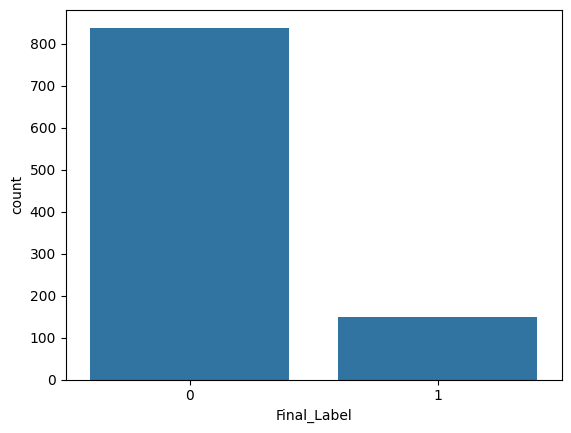

In [10]:
# my plots
sns.countplot(data = final_df, x = 'Final_Label')

In [11]:
#count number of labels
label_counts = final_df["Final_Label"].value_counts()
print(label_counts)

Final_Label
0    838
1    149
Name: count, dtype: int64


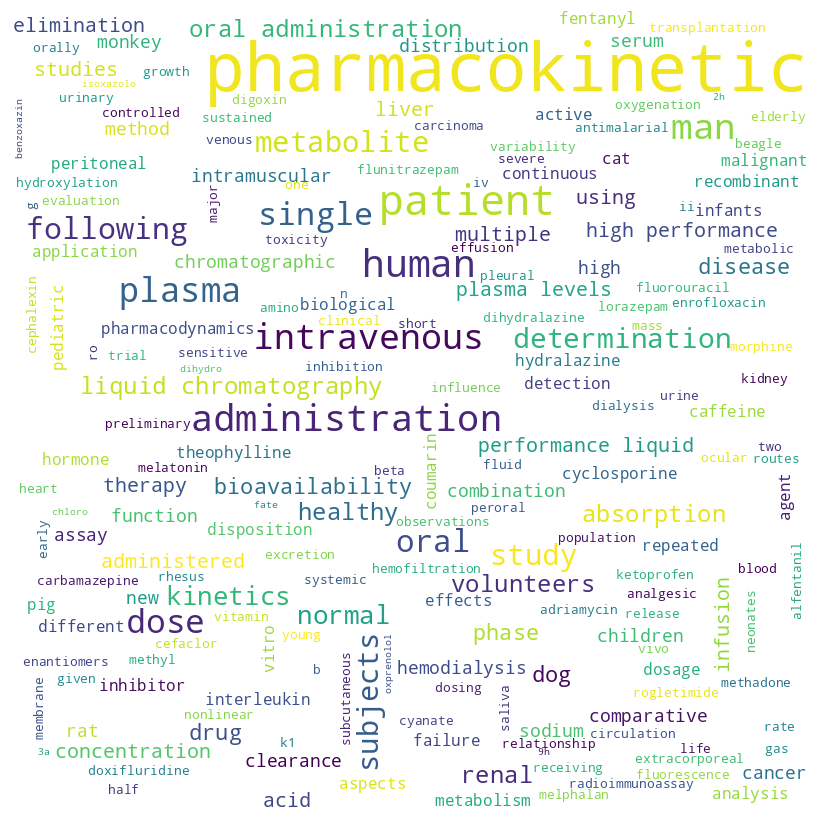

In [16]:
# wordcloud
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
stopwords = set(STOPWORDS)

filtered_df = final_df[final_df['Final_Label'] == 1]

words = ""
for val in filtered_df.title:
    # each val to string
    val = str(val)
    # split the value
    tokens = val.split()
    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
    words += " ".join(tokens)+" "

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(words)


plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()


## Split Data

In [17]:
from sklearn.model_selection import train_test_split

def stratified_train_val_test_split(df_input, stratify_colname='y',
                                         frac_train=0.6, frac_val=0.2, frac_test=0.2,
                                         random_state=None):
    if frac_train + frac_val + frac_test != 1.0:
        raise ValueError('fractions %f, %f, %f do not add up to 1.0' % \
                         (frac_train, frac_val, frac_test))
    if stratify_colname not in df_input.columns:
        raise ValueError('%s is not a column in the dataframe' % (stratify_colname))

    X = df_input
    y = df_input[[stratify_colname]]

    # Split original df to train and temp dataframes.
    df_train, df_temp, y_train, y_temp = train_test_split(X,
                                                          y,
                                                          stratify=y,
                                                          test_size=(1.0 - frac_train),
                                                          random_state=random_state)
    # Split the temp df to val and test dataframes.
    relative_frac_test = frac_test / (frac_val + frac_test)
    df_val, df_test, y_val, y_test = train_test_split(df_temp,
                                                      y_temp,
                                                      stratify=y_temp,
                                                      test_size=relative_frac_test,
                                                      random_state=random_state)

    assert len(df_input) == len(df_train) + len(df_val) + len(df_test)
    return df_train, df_val, df_test

In [19]:
# train data = 70%, test data = 30%
train, val, test = stratified_train_val_test_split(final_df, stratify_colname='Final_Label',
                                         frac_train=0.7, frac_val=0.15, frac_test=0.15,
                                         random_state=42)


test = pd.concat([test, val])

print("Train Data:")
print(train["Final_Label"].value_counts())
print("\nTest Data:")
print(test["Final_Label"].value_counts())

Train Data:
Final_Label
0    586
1    104
Name: count, dtype: int64

Test Data:
Final_Label
0    252
1     45
Name: count, dtype: int64


## Baseline method: TF-IDF

In [21]:
# Function to plot confusion matrix
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

def plot_confusion_matrix(y_test, y_pred):
  fig, ax = plt.subplots(figsize=(5, 2.5))
  ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax, labels=[1,0])
  plt.show()

### Unbalanced classes with scaled loss function

In [23]:
import xgboost as xgb
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer,  TfidfTransformer
from sklearn.metrics import f1_score, confusion_matrix, precision_score, recall_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict
from imblearn.pipeline import make_pipeline as make_pipeline_imb
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import StratifiedKFold

def display_scores(all_scores, field):
    print("\n=============================")
    print(f"3-fold CROSS VALIDATION SCORES for {field}")
    score_names = ["test_f1", "test_precision", "test_recall"]
    for name in score_names:
      scores = all_scores[name]
      print()
      print("{0} scores: {1}, Mean: {2:.3f}, Std: {3:.3f}\n".format(name, scores, np.mean(scores), np.std(scores)))


fields_to_try = ["abstract_and_title", 'title', 'abstract','authors','date', 'journal',  'mesh_terms', 'authors_and_journal']

for field in fields_to_try:
    print(f"--------------------------")
    print(f"Training XGBoost on {field}")
    X_train = train[field]
    y_train = train["Final_Label"]
    unique, counts = np.unique(y_train, return_counts=True)
    weight = counts[0]/counts[1]

    pipe = make_pipeline_imb(TfidfVectorizer(),
                             xgb.XGBClassifier(random_state=1,
                                    n_estimators=148,
                                    objective='binary:logistic',
                                    learning_rate=0.1, # lr
                                    colsample_bytree=1,
                                    max_depth=2, # max depth of tree - larger value will make the model more complex and more likley to overfit
                                    scale_pos_weight=weight,  # sum(negative instances) / sum(positive instances)
                                    nthread=-1,
                                    n_jobs=-1))

    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    cv_scores = cross_validate(pipe, X_train, y_train, scoring=["f1", "precision", "recall"], cv=skf)
    display_scores(cv_scores, field)

    #y_pred = cross_val_predict(pipe,  X_train, y_train, cv=3)
    #plot_confusion_matrix(y_train, y_pred)
    print("=============================\n")

--------------------------
Training XGBoost on abstract_and_title

3-fold CROSS VALIDATION SCORES for abstract_and_title

test_f1 scores: [0.29032258 0.19178082 0.22222222], Mean: 0.235, Std: 0.041


test_precision scores: [0.32142857 0.18421053 0.25      ], Mean: 0.252, Std: 0.056


test_recall scores: [0.26470588 0.2        0.2       ], Mean: 0.222, Std: 0.031


--------------------------
Training XGBoost on title

3-fold CROSS VALIDATION SCORES for title

test_f1 scores: [0.26666667 0.22857143 0.22222222], Mean: 0.239, Std: 0.020


test_precision scores: [0.21428571 0.17142857 0.171875  ], Mean: 0.186, Std: 0.020


test_recall scores: [0.35294118 0.34285714 0.31428571], Mean: 0.337, Std: 0.016


--------------------------
Training XGBoost on abstract

3-fold CROSS VALIDATION SCORES for abstract

test_f1 scores: [0.31884058 0.18181818 0.09230769], Mean: 0.198, Std: 0.093


test_precision scores: [0.31428571 0.19354839 0.1       ], Mean: 0.203, Std: 0.088


test_recall scores: [0.3235

### Balanced by undersampling, no loss scaling

In [24]:
import xgboost as xgb
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer,  TfidfTransformer
from sklearn.metrics import f1_score, confusion_matrix, precision_score, recall_score
from sklearn.model_selection import cross_validate
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import cross_val_predict
from imblearn.pipeline import make_pipeline as make_pipeline_imb
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import StratifiedKFold

def display_scores(all_scores, field):
    print("\n=============================")
    print(f"3-fold CROSS VALIDATION SCORES for {field}")
    score_names = ["test_f1", "test_precision", "test_recall"]
    for name in score_names:
      scores = all_scores[name]
      print()
      print("{0} scores: {1}, Mean: {2:.3f}, Std: {3:.3f}\n".format(name, scores, np.mean(scores), np.std(scores)))


fields_to_try = ["abstract_and_title", 'title', 'abstract','authors','date', 'journal',  'mesh_terms', 'authors_and_journal']

for field in fields_to_try:
    print(f"--------------------------")
    print(f"Training XGBoost on {field}")
    X_train = train[field]
    y_train = train["Final_Label"]
    unique, counts = np.unique(y_train, return_counts=True)
    weight = counts[0]/counts[1]

    pipe = make_pipeline_imb(TfidfVectorizer(),
                             RandomUnderSampler(random_state=42,sampling_strategy="majority"),
                             xgb.XGBClassifier(random_state=1,
                                    n_estimators=148,
                                    objective='binary:logistic',
                                    learning_rate=0.1, # lr
                                    colsample_bytree=1,
                                    max_depth=2, # max depth of tree - larger value will make the model more complex and more likley to overfit
                                    #scale_pos_weight=weight,  # sum(negative instances) / sum(positive instances)
                                    nthread=-1,
                                    n_jobs=-1))

    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    cv_scores = cross_validate(pipe, X_train, y_train, scoring=["f1", "precision", "recall"], cv=skf)
    display_scores(cv_scores, field)

    #y_pred = cross_val_predict(pipe,  X_train, y_train, cv=3)
    #plot_confusion_matrix(y_train, y_pred)
    print("=============================\n")

--------------------------
Training XGBoost on abstract_and_title

3-fold CROSS VALIDATION SCORES for abstract_and_title

test_f1 scores: [0.28368794 0.33557047 0.24827586], Mean: 0.289, Std: 0.036


test_precision scores: [0.18691589 0.21929825 0.16363636], Mean: 0.190, Std: 0.023


test_recall scores: [0.58823529 0.71428571 0.51428571], Mean: 0.606, Std: 0.083


--------------------------
Training XGBoost on title

3-fold CROSS VALIDATION SCORES for title

test_f1 scores: [0.21138211 0.24719101 0.25842697], Mean: 0.239, Std: 0.020


test_precision scores: [0.14606742 0.15384615 0.16083916], Mean: 0.154, Std: 0.006


test_recall scores: [0.38235294 0.62857143 0.65714286], Mean: 0.556, Std: 0.123


--------------------------
Training XGBoost on abstract

3-fold CROSS VALIDATION SCORES for abstract

test_f1 scores: [0.26760563 0.30065359 0.25      ], Mean: 0.273, Std: 0.021


test_precision scores: [0.17592593 0.19491525 0.16      ], Mean: 0.177, Std: 0.014


test_recall scores: [0.5588

## Pre-trained LLMs to generate Sentence Embeddings

---



In [25]:
# load in packages
import torch
!pip install sentence-transformers
# Set the device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.5/171.5 kB 4.9 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [26]:
# function to display scores
def display_scores(all_scores, field):
    print("\n=============================")
    print(f"3-fold CROSS VALIDATION SCORES for {field}")
    score_names = ["test_f1", "test_precision", "test_recall"]
    for name in score_names:
      scores = all_scores[name]
      print()
      print("{0} scores: {1}, Mean: {2:.3f}, Std: {3:.3f}\n".format(name, scores, np.mean(scores), np.std(scores)))

### Unbalanced (but with scaled loss function)

In [27]:
from sentence_transformers import SentenceTransformer
import xgboost as xgb
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict
from imblearn.pipeline import make_pipeline as make_pipeline_imb


bert_encoder_model = SentenceTransformer("microsoft/BiomedNLP-BiomedBERT-base-uncased-abstract")

fields_to_try = ['title', 'abstract', 'authors','date', 'journal',  'mesh_terms', 'authors_and_journal', "abstract_and_title"]

for field in fields_to_try:
    print(f"--------------------------")
    print(f"Training XGBoost on BERT Embeddings of {field}")
    X_train = train[field]
    y_train = train["Final_Label"]
    X_val = val[field]
    y_val = val["Final_Label"]

    unique, counts = np.unique(y_train, return_counts=True)
    weight = counts[0]/counts[1]

    encoded_Xtrain = bert_encoder_model.encode(X_train.to_list(), batch_size=32, device=device,
                                              show_progress_bar=True, output_value='sentence_embedding')

    pipe_bert = make_pipeline_imb(xgb.XGBClassifier(random_state=1,
                                  n_estimators=148,
                                  objective='binary:logistic',
                                  learning_rate=0.1, # lr
                                  colsample_bytree=1,
                                  max_depth=2, # max depth of tree - larger value will make the model more complex and more likley to overfit
                                  scale_pos_weight=weight,  # sum(negative instances) / sum(positive instances)
                                  nthread=-1,
                                  n_jobs=-1))

    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    cv_scores = cross_validate(pipe_bert, encoded_Xtrain, y_train, scoring=["f1", "precision", "recall"], cv=skf)
    display_scores(cv_scores, field)

    #y_pred = cross_val_predict(pipe,  X_train, y_train, cv=3)
    #plot_confusion_matrix(y_train, y_pred)
    print("=============================\n")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/225k [00:00<?, ?B/s]

--------------------------
Training XGBoost on BERT Embeddings of title


Batches:   0%|          | 0/22 [00:00<?, ?it/s]


3-fold CROSS VALIDATION SCORES for title

test_f1 scores: [0.32142857 0.28070175 0.20833333], Mean: 0.270, Std: 0.047


test_precision scores: [0.40909091 0.36363636 0.38461538], Mean: 0.386, Std: 0.019


test_recall scores: [0.26470588 0.22857143 0.14285714], Mean: 0.212, Std: 0.051


--------------------------
Training XGBoost on BERT Embeddings of abstract


Batches:   0%|          | 0/22 [00:00<?, ?it/s]


3-fold CROSS VALIDATION SCORES for abstract

test_f1 scores: [0.35294118 0.33333333 0.31034483], Mean: 0.332, Std: 0.017


test_precision scores: [0.52941176 0.4        0.39130435], Mean: 0.440, Std: 0.063


test_recall scores: [0.26470588 0.28571429 0.25714286], Mean: 0.269, Std: 0.012


--------------------------
Training XGBoost on BERT Embeddings of authors


Batches:   0%|          | 0/22 [00:00<?, ?it/s]


3-fold CROSS VALIDATION SCORES for authors

test_f1 scores: [0.18181818 0.19230769 0.16129032], Mean: 0.178, Std: 0.013


test_precision scores: [0.23809524 0.29411765 0.18518519], Mean: 0.239, Std: 0.044


test_recall scores: [0.14705882 0.14285714 0.14285714], Mean: 0.144, Std: 0.002


--------------------------
Training XGBoost on BERT Embeddings of date


Batches:   0%|          | 0/22 [00:00<?, ?it/s]


3-fold CROSS VALIDATION SCORES for date

test_f1 scores: [0.15873016 0.30769231 0.18666667], Mean: 0.218, Std: 0.065


test_precision scores: [0.17241379 0.33333333 0.175     ], Mean: 0.227, Std: 0.075


test_recall scores: [0.14705882 0.28571429 0.2       ], Mean: 0.211, Std: 0.057


--------------------------
Training XGBoost on BERT Embeddings of journal


Batches:   0%|          | 0/22 [00:00<?, ?it/s]


3-fold CROSS VALIDATION SCORES for journal

test_f1 scores: [0.17241379 0.29333333 0.10526316], Mean: 0.190, Std: 0.078


test_precision scores: [0.20833333 0.275      0.13636364], Mean: 0.207, Std: 0.057


test_recall scores: [0.14705882 0.31428571 0.08571429], Mean: 0.182, Std: 0.097


--------------------------
Training XGBoost on BERT Embeddings of mesh_terms


Batches:   0%|          | 0/22 [00:00<?, ?it/s]


3-fold CROSS VALIDATION SCORES for mesh_terms

test_f1 scores: [0.17857143 0.29032258 0.1509434 ], Mean: 0.207, Std: 0.060


test_precision scores: [0.22727273 0.33333333 0.22222222], Mean: 0.261, Std: 0.051


test_recall scores: [0.14705882 0.25714286 0.11428571], Mean: 0.173, Std: 0.061


--------------------------
Training XGBoost on BERT Embeddings of authors_and_journal


Batches:   0%|          | 0/22 [00:00<?, ?it/s]


3-fold CROSS VALIDATION SCORES for authors_and_journal

test_f1 scores: [0.17857143 0.2295082  0.19354839], Mean: 0.201, Std: 0.021


test_precision scores: [0.22727273 0.26923077 0.22222222], Mean: 0.240, Std: 0.021


test_recall scores: [0.14705882 0.2        0.17142857], Mean: 0.173, Std: 0.022


--------------------------
Training XGBoost on BERT Embeddings of abstract_and_title


Batches:   0%|          | 0/22 [00:00<?, ?it/s]


3-fold CROSS VALIDATION SCORES for abstract_and_title

test_f1 scores: [0.31372549 0.2962963  0.22641509], Mean: 0.279, Std: 0.038


test_precision scores: [0.47058824 0.42105263 0.33333333], Mean: 0.408, Std: 0.057


test_recall scores: [0.23529412 0.22857143 0.17142857], Mean: 0.212, Std: 0.029




### Balanced (by undersampling, no loss scaling)

In [28]:
from sentence_transformers import SentenceTransformer
import xgboost as xgb
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict
from imblearn.pipeline import make_pipeline as make_pipeline_imb
from imblearn.under_sampling import RandomUnderSampler


bert_encoder_model = SentenceTransformer("microsoft/BiomedNLP-BiomedBERT-base-uncased-abstract")

fields_to_try = ['title', 'abstract', 'authors','date', 'journal',  'mesh_terms', 'authors_and_journal', "abstract_and_title"]

for field in fields_to_try:
    print(f"--------------------------")
    print(f"Training XGBoost on BERT Embeddings of {field}")
    X_train = train[field]
    y_train = train["Final_Label"]
    #X_val = val[field]
    #y_val = val["Final_Label"]

    unique, counts = np.unique(y_train, return_counts=True)
    weight = counts[0]/counts[1]

    encoded_Xtrain = bert_encoder_model.encode(X_train.to_list(), batch_size=32, device=device,
                                              show_progress_bar=True, output_value='sentence_embedding')

    pipe_bert = make_pipeline_imb(RandomUnderSampler(random_state=42,sampling_strategy="majority"),
                                   xgb.XGBClassifier(random_state=1,
                                    n_estimators=148,
                                    objective='binary:logistic',
                                    learning_rate=0.1, # lr
                                    colsample_bytree=1,
                                    max_depth=2, # max depth of tree - larger value will make the model more complex and more likley to overfit
                                    #scale_pos_weight=weight,  # sum(negative instances) / sum(positive instances)
                                    nthread=-1,
                                    n_jobs=-1))



    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    cv_scores = cross_validate(pipe_bert, encoded_Xtrain, y_train, scoring=["f1", "precision", "recall"], cv=skf)
    display_scores(cv_scores, field)

    #y_pred = cross_val_predict(pipe,  X_train, y_train, cv=3)
    #plot_confusion_matrix(y_train, y_pred)
    print("=============================\n")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


--------------------------
Training XGBoost on BERT Embeddings of title


Batches:   0%|          | 0/22 [00:00<?, ?it/s]


3-fold CROSS VALIDATION SCORES for title

test_f1 scores: [0.26751592 0.28571429 0.3030303 ], Mean: 0.285, Std: 0.015


test_precision scores: [0.17073171 0.19387755 0.20618557], Mean: 0.190, Std: 0.015


test_recall scores: [0.61764706 0.54285714 0.57142857], Mean: 0.577, Std: 0.031


--------------------------
Training XGBoost on BERT Embeddings of abstract


Batches:   0%|          | 0/22 [00:00<?, ?it/s]


3-fold CROSS VALIDATION SCORES for abstract

test_f1 scores: [0.37878788 0.36923077 0.33333333], Mean: 0.360, Std: 0.020


test_precision scores: [0.25510204 0.25263158 0.22018349], Mean: 0.243, Std: 0.016


test_recall scores: [0.73529412 0.68571429 0.68571429], Mean: 0.702, Std: 0.023


--------------------------
Training XGBoost on BERT Embeddings of authors


Batches:   0%|          | 0/22 [00:00<?, ?it/s]


3-fold CROSS VALIDATION SCORES for authors

test_f1 scores: [0.256      0.27272727 0.30136986], Mean: 0.277, Std: 0.019


test_precision scores: [0.17582418 0.17647059 0.1981982 ], Mean: 0.183, Std: 0.010


test_recall scores: [0.47058824 0.6        0.62857143], Mean: 0.566, Std: 0.069


--------------------------
Training XGBoost on BERT Embeddings of date


Batches:   0%|          | 0/22 [00:00<?, ?it/s]


3-fold CROSS VALIDATION SCORES for date

test_f1 scores: [0.25       0.26356589 0.30656934], Mean: 0.273, Std: 0.024


test_precision scores: [0.16101695 0.18085106 0.20588235], Mean: 0.183, Std: 0.018


test_recall scores: [0.55882353 0.48571429 0.6       ], Mean: 0.548, Std: 0.047


--------------------------
Training XGBoost on BERT Embeddings of journal


Batches:   0%|          | 0/22 [00:00<?, ?it/s]


3-fold CROSS VALIDATION SCORES for journal

test_f1 scores: [0.29577465 0.26086957 0.28813559], Mean: 0.282, Std: 0.015


test_precision scores: [0.19444444 0.17475728 0.20481928], Mean: 0.191, Std: 0.012


test_recall scores: [0.61764706 0.51428571 0.48571429], Mean: 0.539, Std: 0.057


--------------------------
Training XGBoost on BERT Embeddings of mesh_terms


Batches:   0%|          | 0/22 [00:00<?, ?it/s]


3-fold CROSS VALIDATION SCORES for mesh_terms

test_f1 scores: [0.29370629 0.28985507 0.26388889], Mean: 0.282, Std: 0.013


test_precision scores: [0.19266055 0.19417476 0.17431193], Mean: 0.187, Std: 0.009


test_recall scores: [0.61764706 0.57142857 0.54285714], Mean: 0.577, Std: 0.031


--------------------------
Training XGBoost on BERT Embeddings of authors_and_journal


Batches:   0%|          | 0/22 [00:00<?, ?it/s]


3-fold CROSS VALIDATION SCORES for authors_and_journal

test_f1 scores: [0.25165563 0.24358974 0.29411765], Mean: 0.263, Std: 0.022


test_precision scores: [0.16239316 0.15702479 0.1980198 ], Mean: 0.172, Std: 0.018


test_recall scores: [0.55882353 0.54285714 0.57142857], Mean: 0.558, Std: 0.012


--------------------------
Training XGBoost on BERT Embeddings of abstract_and_title


Batches:   0%|          | 0/22 [00:00<?, ?it/s]


3-fold CROSS VALIDATION SCORES for abstract_and_title

test_f1 scores: [0.31428571 0.32       0.3649635 ], Mean: 0.333, Std: 0.023


test_precision scores: [0.20754717 0.22222222 0.24509804], Mean: 0.225, Std: 0.015


test_recall scores: [0.64705882 0.57142857 0.71428571], Mean: 0.644, Std: 0.058




## Hyperparameter Grid Search

In [29]:
# Function to display results
def report_best_scores(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [30]:
# randomizedsearch
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html

from scipy.stats import uniform, randint
from sklearn.model_selection import RandomizedSearchCV
from imblearn.pipeline import Pipeline
import xgboost as xgb

# select features
X_train = train["abstract"]
y_train = train["Final_Label"]
encoded_Xtrain = bert_encoder_model.encode(X_train.to_list(), batch_size=32, device=device,
                                              show_progress_bar=True, output_value='sentence_embedding')

#create pipeline
rus = RandomUnderSampler(random_state=42,sampling_strategy="majority")
clf = xgb.XGBClassifier()
xgb_pipe = Pipeline([("rus", rus),("clf", clf)])

# set hyperparameter ranges to tune
params = {
    "clf__colsample_bytree": uniform(0.7, 0.3),
    "clf__gamma": uniform(0, 2),
    "clf__learning_rate": uniform(0.0001, 0.3),
    "clf__max_depth": randint(2, 6),
    "clf__n_estimators": randint(100, 150),
    "clf__subsample": uniform(0.8, 0.3),
    "clf__min_child_weight": uniform(1,5)
}

# carry out random search and print best scores
random_search = RandomizedSearchCV(xgb_pipe, param_distributions=params, random_state=42, n_iter=200, cv=3,
                                   verbose=1, n_jobs=1, return_train_score=False)

random_search.fit(encoded_Xtrain, y_train)

report_best_scores(random_search.cv_results_, 1)

print('\n Best estimator:')
print(random_search.best_estimator_)
print('\n Best hyperparameters:')
print(random_search.best_params_)

Batches:   0%|          | 0/22 [00:00<?, ?it/s]

Fitting 3 folds for each of 200 candidates, totalling 600 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
219 fits failed out of a total of 600.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/imblearn/pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgbo

Model with rank: 1
Mean validation score: 0.603 (std: 0.046)
Parameters: {'clf__colsample_bytree': 0.8476348879238614, 'clf__gamma': 0.5164887765979167, 'clf__learning_rate': 0.1378407268714784, 'clf__max_depth': 3, 'clf__min_child_weight': 4.104028422110456, 'clf__n_estimators': 101, 'clf__subsample': 0.8986254830862526}


 Best estimator:
Pipeline(steps=[('rus',
                 RandomUnderSampler(random_state=42,
                                    sampling_strategy='majority')),
                ('clf',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8476348879238614, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=0.5164887...
                               grow_policy=None

## Early Stopping (to prevent overfitting)

In [31]:
from imblearn.pipeline import Pipeline

# select features
X = train["abstract"]
y = train["Final_Label"]

# split data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

# encode text
encoded_Xtrain = bert_encoder_model.encode(X_train.to_list(), batch_size=32, device=device,
                                              show_progress_bar=True, output_value='sentence_embedding')
encoded_Xval = bert_encoder_model.encode(X_val.to_list(), batch_size=32, device=device,
                                              show_progress_bar=True, output_value='sentence_embedding')

# set up pipeline with tuned hyperparameters
rus = RandomUnderSampler(random_state=42,sampling_strategy="majority")
clf = xgb.XGBClassifier(objective="binary:logistic",
                                      random_state=1,
                                      learning_rate=0.1378407268714784,
                                      max_depth=3,
                                      n_estimators = 101,
                                      subsample=0.8986254830862526,
                                      min_child_weight= 4.104028422110456,
                                      gamma=0.5164887765979167,
                                      colsample_bytree= 0.8476348879238614)
tuned_xgb_model = Pipeline([("rus", rus),("clf", clf)])

# fit final model with early stopping (observing the point at which the accuracy on the held out validation set does not increased for 2 epochs and stopping)
tuned_xgb_model.fit(encoded_Xtrain, y_train, clf__early_stopping_rounds=2, clf__eval_set=[(encoded_Xval, y_val)])

Batches:   0%|          | 0/15 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

[0]	validation_0-logloss:0.68179
[1]	validation_0-logloss:0.67263
[2]	validation_0-logloss:0.66742
[3]	validation_0-logloss:0.66852
[4]	validation_0-logloss:0.67308


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Pipeline(steps=[('rus',
                 RandomUnderSampler(random_state=42,
                                    sampling_strategy='majority')),
                ('clf',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8476348879238614, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=0.5164887...
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.1378407268714784, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=3,
                               max_leaves=None,
                               min_child_weight=4.104028422110456, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=101, n_jobs=None,
                               num_parallel_tree=None, random_state=1, ...))])

## Evaluate Final Pipeline on the Unseen Test Set

Again as above, please feel free to add anything here to the evaluation - you can check out different Machine Learning evaluation metrics and most can be implemented with sklearn metrics => https://scikit-learn.org/stable/modules/model_evaluation.html

In [32]:
# Define a function to plot the confusion matrix
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

def plot_confusion_matrix(y_test, y_pred):
  fig, ax = plt.subplots(figsize=(5, 2.5))
  ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax, labels=[1,0])
  plt.show()

In [33]:
# assign best model
best_model = tuned_xgb_model

# set X test and y test
X_test = test["abstract"]
y_test = test["Final_Label"]

# encode test set with BERT
encoded_Xtest = bert_encoder_model.encode(X_test.to_list(), batch_size=32, device=device,
                                              show_progress_bar=True, output_value='sentence_embedding')

Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Precision For Test Data: -> 0.25
Recall For Test Data: -> 0.64
F1 Score For Test Data: -> 0.36


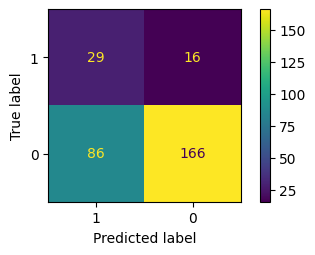

In [34]:
y_test_pred = best_model.predict(encoded_Xtest)
print(f'Precision For Test Data: -> {round(precision_score(y_test, y_test_pred),2)}')
print(f'Recall For Test Data: -> {round(recall_score(y_test, y_test_pred),2)}')
print(f'F1 Score For Test Data: -> {round(f1_score(y_test, y_test_pred),2)}')
plot_confusion_matrix(y_test, y_test_pred)